In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess

In [78]:
sales_train_validation = pd.read_csv('./Walmart Data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('./Walmart Data/sales_train_validation.csv')
sell_prices = pd.read_csv('./Walmart Data/sell_prices.csv')
calendar = pd.read_csv('./Walmart Data/calendar.csv')
sample_submission = pd.read_csv('./Walmart Data/sample_submission.csv')

In [79]:
days_with_events = calendar[(calendar['event_name_1'].notna()) | (calendar['event_name_2'].notna())].shape[0]
total_days = calendar.shape[0]
days_without_events = total_days - days_with_events

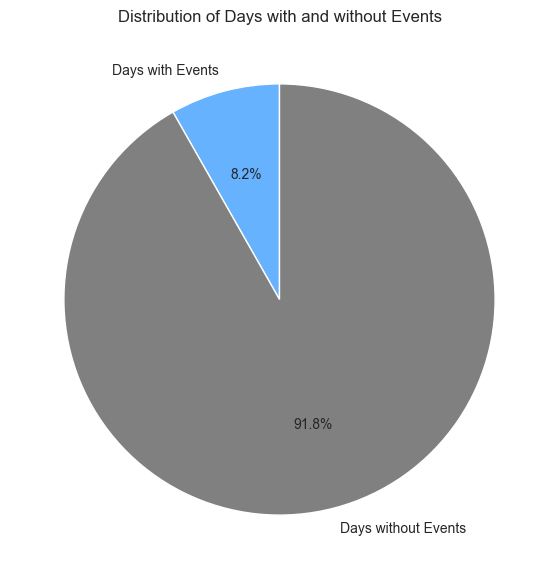

In [80]:
event_data = [days_with_events, days_without_events]
labels = ['Days with Events', 'Days without Events']
colors = ['#66b2ff', '#808080']

plt.figure(figsize=(7,7))
plt.pie(event_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Days with and without Events')
plt.show()

Religious    33.532934
National     31.137725
Cultural     24.550898
Sporting     10.778443
Name: count, dtype: float64


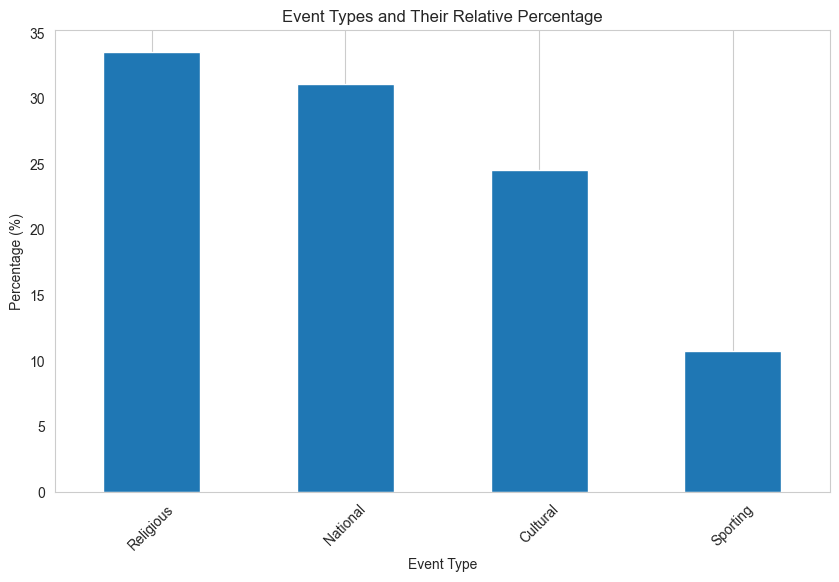

In [81]:
# Concatenating event types from both columns
all_event_types = pd.concat([calendar['event_type_1'], calendar['event_type_2']]).dropna()

# Calculating the frequency of each event type
event_type_counts = all_event_types.value_counts()

# Calculating the relative percentage
event_type_percent = (event_type_counts / event_type_counts.sum()) * 100

print(event_type_percent)

plt.figure(figsize=(10,6))
event_type_percent.plot(kind='bar')
plt.title('Event Types and Their Relative Percentage')
plt.ylabel('Percentage (%)')
plt.xlabel('Event Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [82]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [83]:
# Create a new column for combined event types to check if they have different impact on sales
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2']) 
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)


calendar_subset = calendar[['date', 'combined_event_type']]

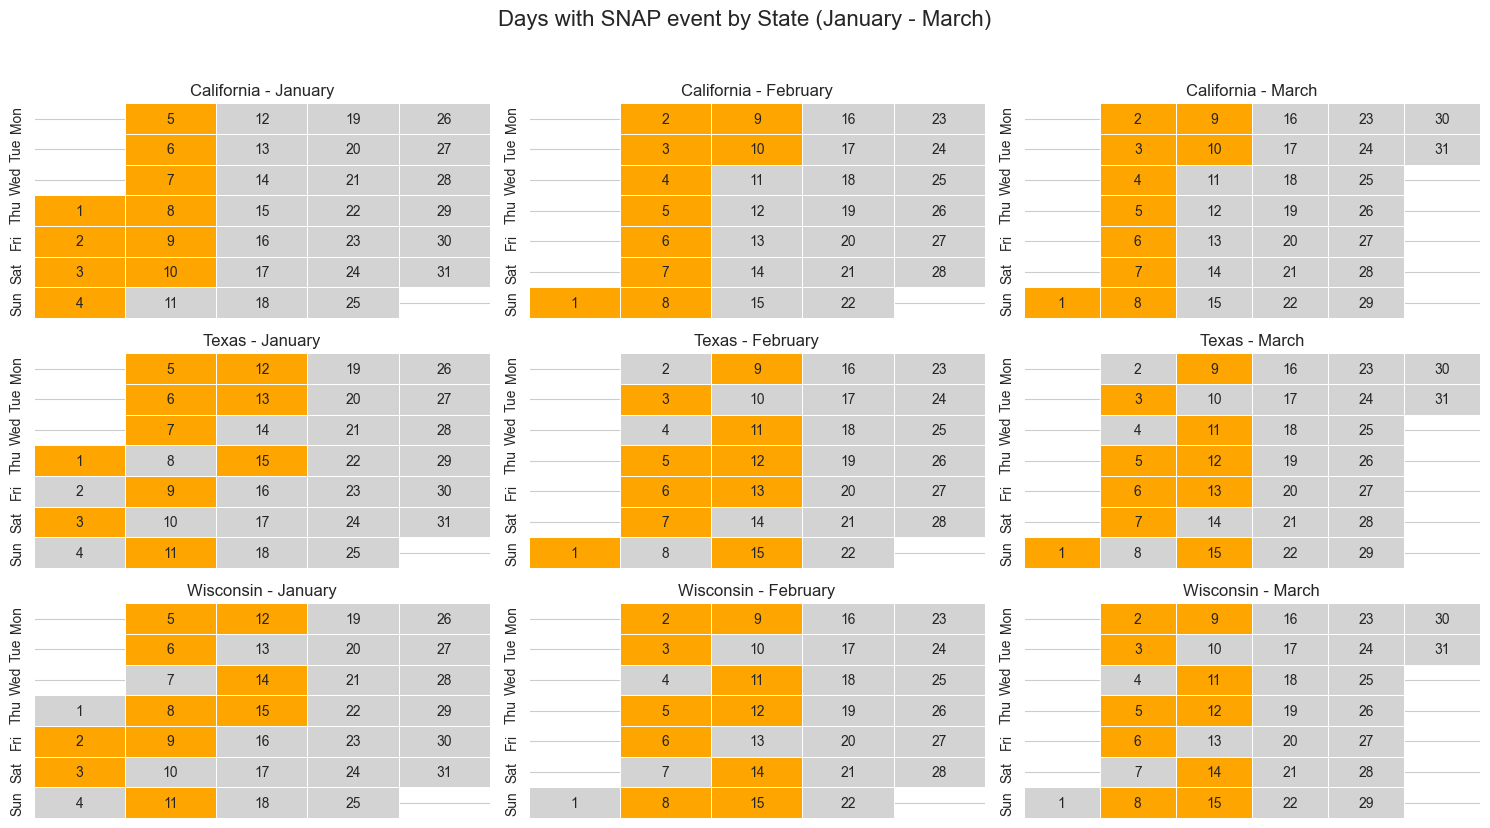

In [85]:
def plot_snap_calendar(axs, df, state_col, state_name):

    df['week'] = df['date'].dt.isocalendar().week
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.dayofweek
    
    for i, month in enumerate(df['month'].unique(), start=0):
        month_name = df[df['month'] == month]['date'].dt.strftime('%B').iloc[0]
        ax = axs[i]
        
        data_month = df[df['month'] == month]
        
        # Determine starting day of the month and adjust matrix
        start_day = data_month['weekday'].iloc[0]
        data_for_heatmap = np.full((7, data_month['week'].nunique()), np.nan)
        day_annotation = np.full((7, data_month['week'].nunique()), '', dtype=object)
        
        col = 0
        for idx, row in data_month.iterrows():
            data_for_heatmap[start_day, col] = row[state_col]
            day_annotation[start_day, col] = str(row['date'].day)
            
            # Move to next day of the week or wrap around
            start_day += 1
            if start_day > 6:
                start_day = 0
                col += 1  # Move to next week
        
        sns.heatmap(data_for_heatmap, cmap=['lightgray', 'orange'], linewidths=0.5, linecolor='white', cbar=False, ax=ax,
                    annot=day_annotation, fmt='')

        ax.set_title(f"{state_name} - {month_name}")
        ax.set_yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
        ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([]) 
        ax.set_xticklabels([]) 

fig, axs = plt.subplots(3, 3, figsize=(15, 8))  # 3 states, 3 months


filtered_calendar = calendar[(calendar['date'].dt.year == 2015) & (calendar['date'].dt.month <= 3)].copy()

plot_snap_calendar(axs[0], filtered_calendar, 'snap_CA', 'California')
plot_snap_calendar(axs[1], filtered_calendar, 'snap_TX', 'Texas')
plot_snap_calendar(axs[2], filtered_calendar, 'snap_WI', 'Wisconsin')

fig.suptitle('Days with SNAP event by State (January - March)', y=1.03, fontsize=16)
plt.tight_layout()


In [7]:
'''Data pre-processing'''

'Data pre-processing'

In [86]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')

# Extract day number
sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)

# Merge with calendar
data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')

data['date'] = pd.to_datetime(data['date'])

# Merge with sell prices
data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [87]:
data.tail()
#data = data[(data['date'].dt.year != 2011) & (data['date'].dt.year != 2016)]

In [92]:
# Create a list of all the event/holiday columns in your dataframe
event_columns = [col for col in data.columns if 'event' in col]

# Create a new column 'is_event_or_holiday' that is True if any event/holiday is True, False otherwise
data['is_event_or_holiday'] = data[event_columns].any(axis=1)

In [1]:
'''EDA'''

'EDA'

In [93]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'weekday' column to category type with ordered days
data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)

In [94]:
df_daily = data.groupby('date').agg({'sales': 'sum', 'is_event_or_holiday': 'max'}).reset_index()

In [95]:
df_daily_state = data.groupby(['date', 'state_id']).agg({'sales': 'sum', 'is_event_or_holiday': 'max'}).reset_index()

In [96]:
# Set 'date' as the index
df_daily.set_index('date', inplace=True)

In [97]:
# Group by whether there's an event, and if there is, by its type
event_sales = data.groupby(['combined_event_type']).agg({'sales': 'mean'}).reset_index()

# Add a row for non-event days
non_event_sales = data[data['combined_event_type'].isna()].agg({'sales': 'mean'})
non_event_sales = pd.DataFrame([['No Event', non_event_sales['sales']]], columns=['combined_event_type', 'sales'])

# Concatenate the two DataFrames
event_sales = pd.concat([event_sales, non_event_sales], ignore_index=True)

<Figure size 1200x800 with 0 Axes>

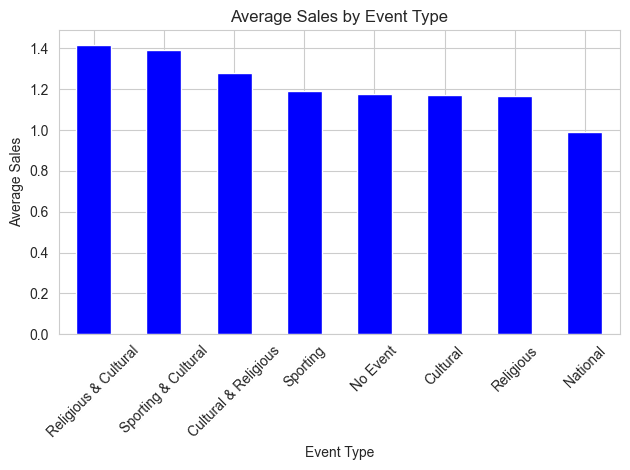

In [98]:
plt.figure(figsize=(12, 8))
event_sales.sort_values('sales', ascending=False).plot.bar(x='combined_event_type', y='sales', legend=False, color='blue')
plt.title('Average Sales by Event Type')
plt.ylabel('Average Sales')
plt.xlabel('Event Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [99]:
data['combined_event_type'].fillna('No Event', inplace=True)

In [100]:
daily_total_sales_by_cat = data.groupby(['date', 'cat_id', 'combined_event_type']).agg({'sales': 'sum'}).reset_index()
daily_avg_sales_by_cat = daily_total_sales_by_cat.groupby(['cat_id', 'combined_event_type']).agg({'sales': 'mean'}).reset_index()

In [101]:
non_event_avg_sales_by_cat = daily_avg_sales_by_cat[daily_avg_sales_by_cat['combined_event_type'] == 'No Event'][['cat_id', 'sales']]
non_event_avg_sales_by_cat.set_index('cat_id', inplace=True)

daily_avg_sales_by_cat['relative_sales'] = daily_avg_sales_by_cat.apply(lambda row: row['sales'] / non_event_avg_sales_by_cat.loc[row['cat_id'], 'sales'], axis=1)

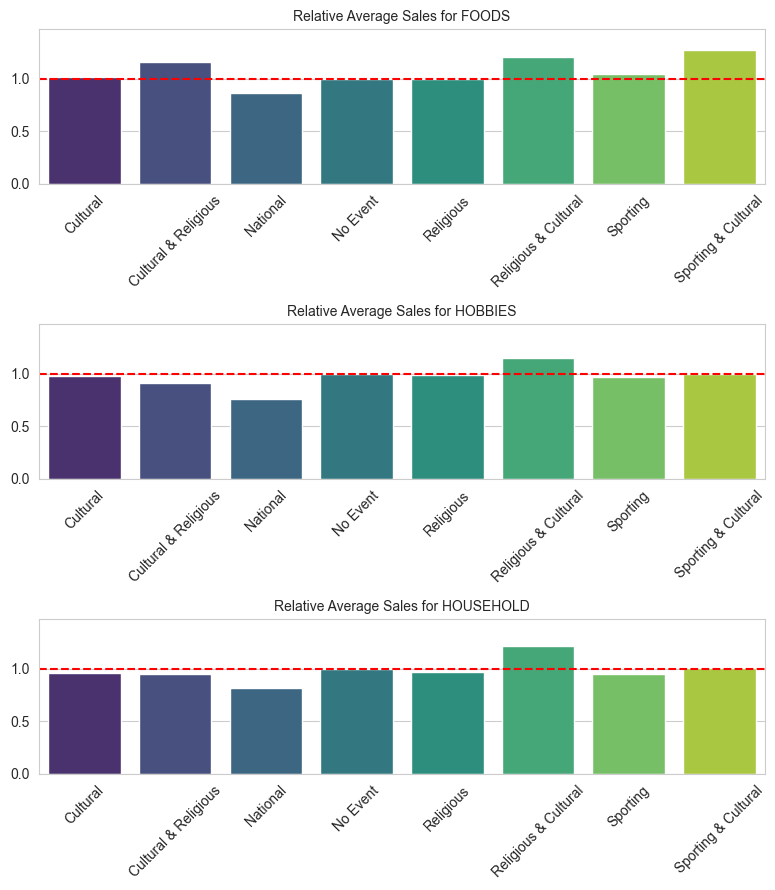

In [102]:
categories = daily_avg_sales_by_cat['cat_id'].unique()

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=len(categories), figsize=(8, 3*len(categories)))

for i, cat in enumerate(categories):
    cat_data = daily_avg_sales_by_cat[daily_avg_sales_by_cat['cat_id'] == cat]
    sns.barplot(x="combined_event_type", y="relative_sales", data=cat_data, palette="viridis", ax=axes[i])
    
    axes[i].set_title(f'Relative Average Sales for {cat}', fontsize=10)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_ylim(0, daily_avg_sales_by_cat['relative_sales'].max() + 0.2)  # set a consistent y-limit for better comparison
    axes[i].axhline(1, color='red', linestyle='--')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [103]:
grouped_sales = data.groupby(['date', 'state_id', 'snap_CA', 'snap_TX', 'snap_WI']).sales.sum().reset_index()

In [104]:
grouped_sales['SNAP'] = 0 
grouped_sales.loc[grouped_sales['state_id'] == 'CA', 'SNAP'] = grouped_sales['snap_CA']
grouped_sales.loc[grouped_sales['state_id'] == 'TX', 'SNAP'] = grouped_sales['snap_TX']
grouped_sales.loc[grouped_sales['state_id'] == 'WI', 'SNAP'] = grouped_sales['snap_WI']

grouped_sales.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

avg_daily_sales_by_state = grouped_sales.groupby(['state_id', 'SNAP']).sales.mean().reset_index()

non_snap_avg_sales_by_state = avg_daily_sales_by_state[avg_daily_sales_by_state['SNAP'] == 0][['state_id', 'sales']]
non_snap_avg_sales_by_state.set_index('state_id', inplace=True)

avg_daily_sales_by_state['relative_sales'] = avg_daily_sales_by_state.apply(lambda row: row['sales'] / non_snap_avg_sales_by_state.loc[row['state_id'], 'sales'], axis=1)

print(avg_daily_sales_by_state)

  state_id  SNAP         sales  relative_sales
0       CA     0  15147.517839        1.000000
1       CA     1  16372.056250        1.080841
2       TX     0   9845.334353        1.000000
3       TX     1  10965.531250        1.113779
4       WI     0   9210.452599        1.000000
5       WI     1  11276.443750        1.224309


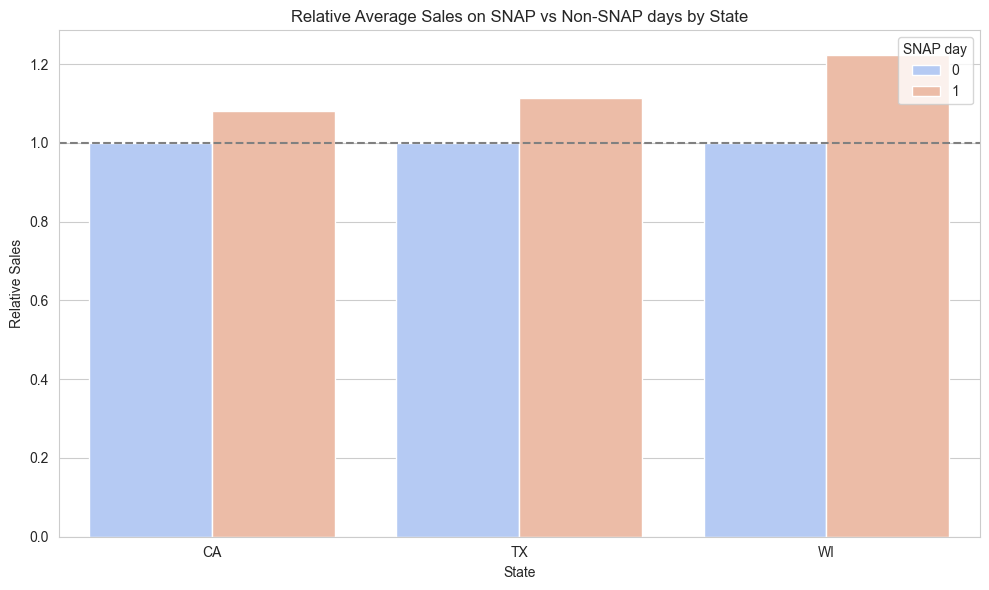

In [105]:
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_daily_sales_by_state, x='state_id', y='relative_sales', hue='SNAP', palette="coolwarm")

plt.title('Relative Average Sales on SNAP vs Non-SNAP days by State')
plt.ylabel('Relative Sales')
plt.xlabel('State')
plt.legend(title="SNAP day", loc='upper right')
plt.axhline(1, color="gray", linestyle="--")

plt.tight_layout()
plt.show()

c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


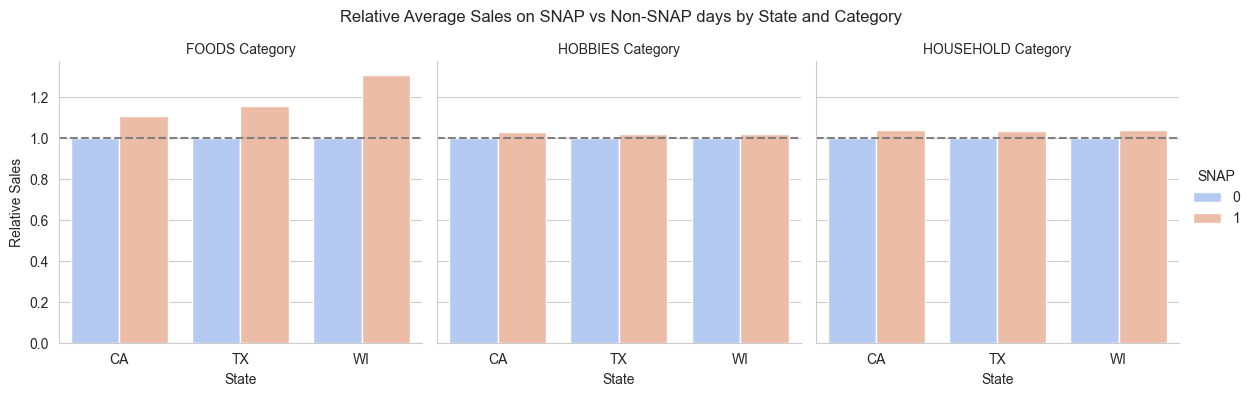

In [106]:
grouped_sales_cat = data.groupby(['date', 'state_id', 'cat_id', 'snap_CA', 'snap_TX', 'snap_WI']).sales.sum().reset_index()

grouped_sales_cat['SNAP'] = 0
grouped_sales_cat.loc[grouped_sales_cat['state_id'] == 'CA', 'SNAP'] = grouped_sales_cat['snap_CA']
grouped_sales_cat.loc[grouped_sales_cat['state_id'] == 'TX', 'SNAP'] = grouped_sales_cat['snap_TX']
grouped_sales_cat.loc[grouped_sales_cat['state_id'] == 'WI', 'SNAP'] = grouped_sales_cat['snap_WI']

grouped_sales_cat.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

avg_daily_sales_by_state_cat = grouped_sales_cat.groupby(['state_id', 'cat_id', 'SNAP']).sales.mean().reset_index()

non_snap_avg_sales_by_state_cat = avg_daily_sales_by_state_cat[avg_daily_sales_by_state_cat['SNAP'] == 0][['state_id', 'cat_id', 'sales']]
non_snap_avg_sales_by_state_cat.set_index(['state_id', 'cat_id'], inplace=True)

avg_daily_sales_by_state_cat['relative_sales'] = avg_daily_sales_by_state_cat.apply(lambda row: row['sales'] / non_snap_avg_sales_by_state_cat.loc[(row['state_id'], row['cat_id']), 'sales'], axis=1)

g = sns.catplot(data=avg_daily_sales_by_state_cat, x='state_id', y='relative_sales', hue='SNAP', col='cat_id', kind='bar', palette="coolwarm", height=4, aspect=1)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Relative Average Sales on SNAP vs Non-SNAP days by State and Category')
for ax in g.axes.flat:
    ax.axhline(1, color="gray", linestyle="--")
g.set_axis_labels("State", "Relative Sales")
g.set_titles("{col_name} Category")

plt.show()


In [107]:
avg_daily_sales_by_state_cat.head(15)

,state_id,cat_id,SNAP,sales,relative_sales
0,CA,FOODS,0,10043.068298,1.000000
1,CA,FOODS,1,11099.131250,1.105153
2,CA,HOBBIES,0,1592.875637,1.000000
3,CA,HOBBIES,1,1636.247917,1.027229
4,CA,HOUSEHOLD,0,3511.573904,1.000000
5,CA,HOUSEHOLD,1,3636.677083,1.035626
6,TX,FOODS,0,6603.779817,1.000000
7,TX,FOODS,1,7630.210417,1.155431
8,TX,HOBBIES,0,849.133537,1.000000
9,TX,HOBBIES,1,863.833333,1.017312


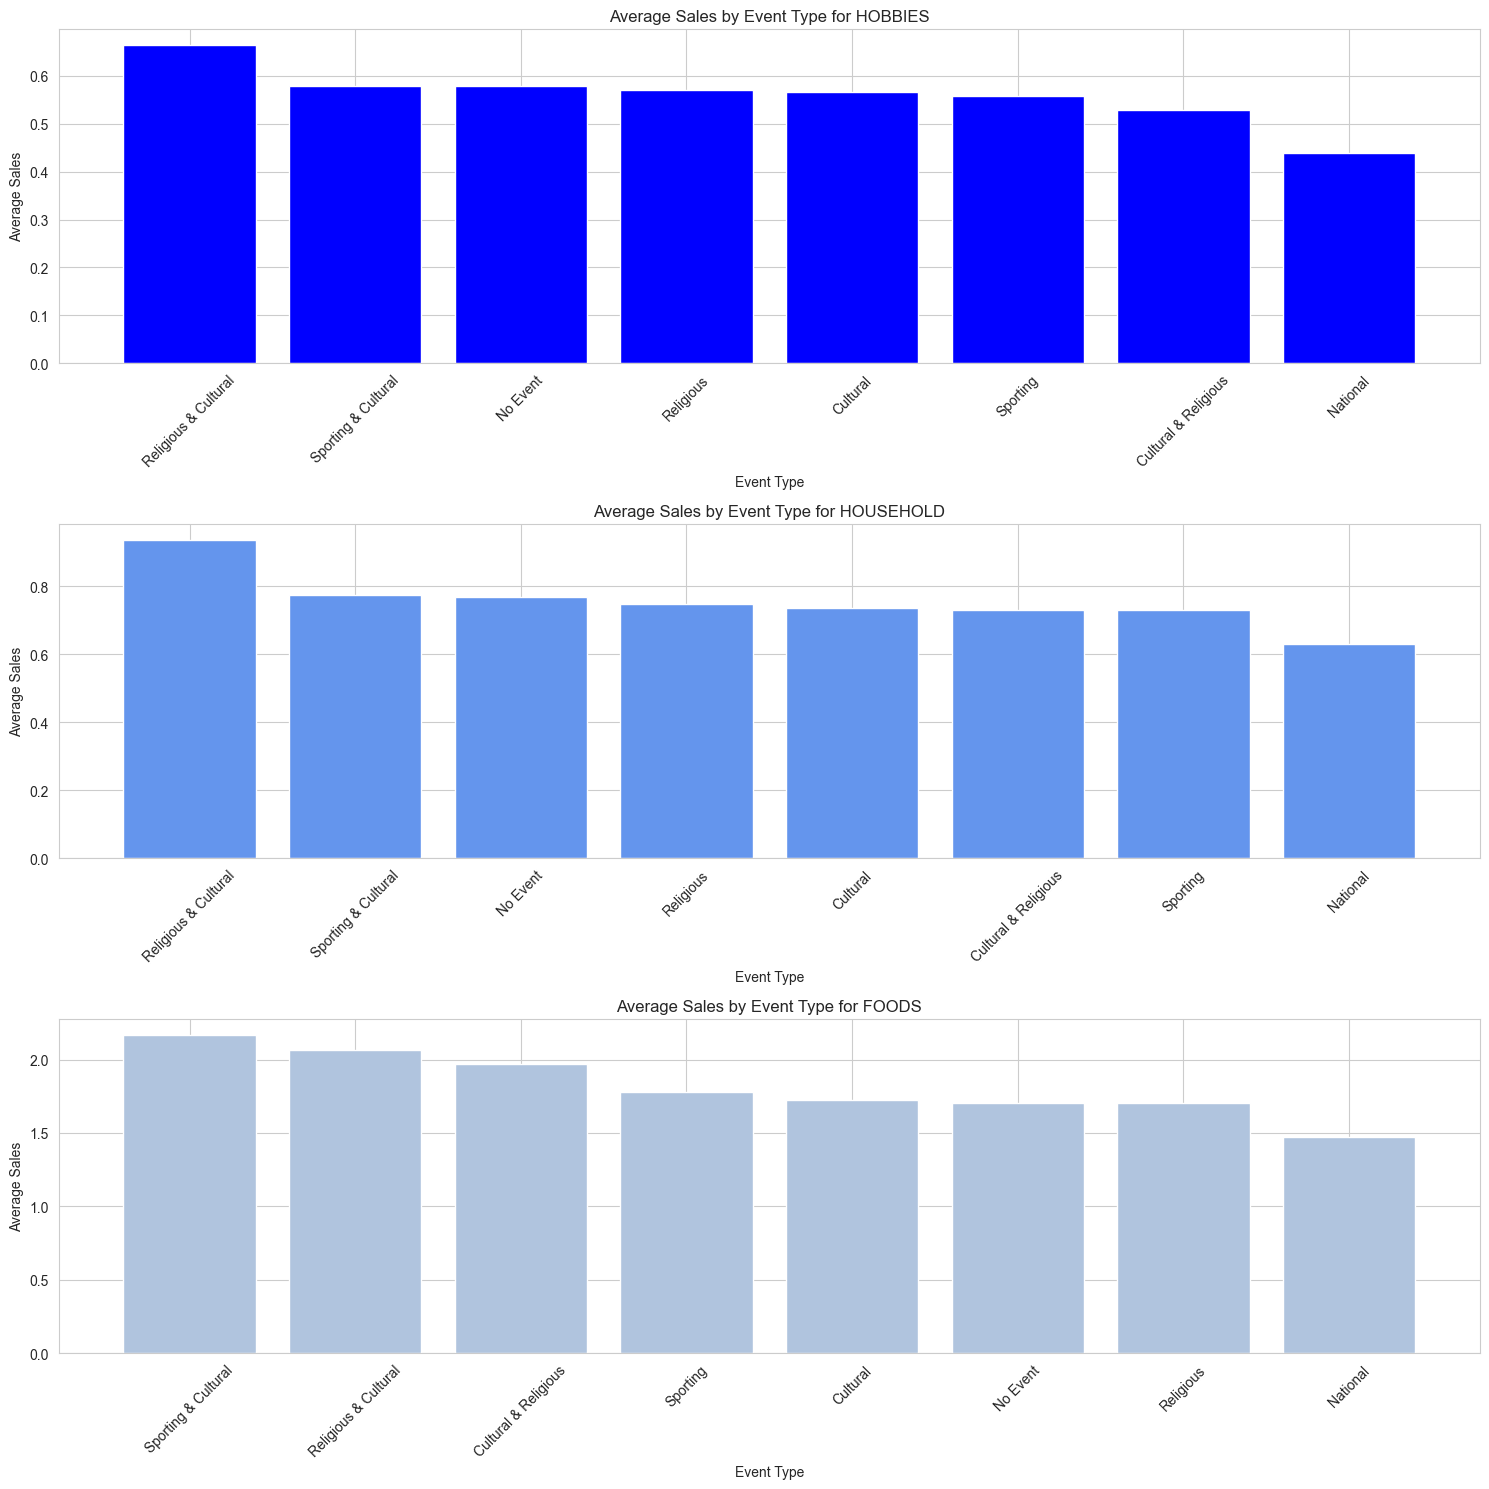

In [108]:
event_cat_sales = data.groupby(['combined_event_type', 'cat_id']).agg({'sales': 'mean'}).reset_index()

for category in data['cat_id'].unique():
    non_event_sales = data[(data['combined_event_type'].isna()) & (data['cat_id'] == category)].agg({'sales': 'mean'})
    non_event_sales_row = pd.DataFrame([['No Event', category, non_event_sales['sales']]], columns=['combined_event_type', 'cat_id', 'sales'])
    event_cat_sales = pd.concat([event_cat_sales, non_event_sales_row], ignore_index=True)

# Plotting
unique_categories = data['cat_id'].unique()
num_categories = len(unique_categories)

fig, axes = plt.subplots(num_categories, 1, figsize=(15, 5 * num_categories))

colors = ['blue', 'cornflowerblue', 'lightsteelblue']
color_mapping = {category: color for category, color in zip(unique_categories, colors)}

for i, category in enumerate(unique_categories):
    subset = event_cat_sales[event_cat_sales['cat_id'] == category].sort_values('sales', ascending=False)
    
    axes[i].bar(subset['combined_event_type'], subset['sales'], color=color_mapping[category])
    axes[i].set_title(f'Average Sales by Event Type for {category}')
    axes[i].set_ylabel('Average Sales')
    axes[i].set_xlabel('Event Type')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [110]:
data['combined_event_type'] = data['combined_event_type'].replace('No Event', np.nan)

In [111]:
top_products = data.groupby(['cat_id', 'item_id']).sales.sum().reset_index()
top_5_products_per_category = top_products.groupby('cat_id').apply(lambda x: x.nlargest(5, 'sales')).reset_index(drop=True)


In [114]:
top_5_products = top_5_products_per_category['item_id'].tolist()

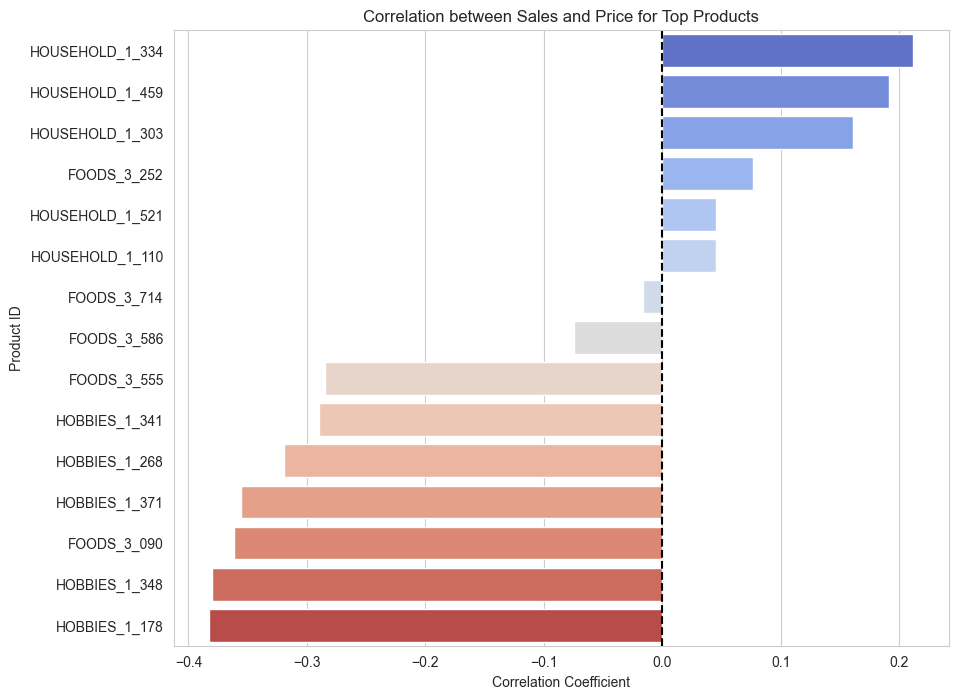

In [116]:
df = correlation_df.sort_values(by="Correlation", ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=df, y="Product", x="Correlation", palette="coolwarm")
plt.axvline(x=0, color='black', linestyle='--') 
plt.title("Correlation between Sales and Price for Top Products")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Product ID")
plt.show()

In [39]:
top_5_products_per_category.head()

,cat_id,item_id,sales
0,FOODS,FOODS_3_090,836076
1,FOODS,FOODS_3_586,691253
2,FOODS,FOODS_3_252,430349
3,FOODS,FOODS_3_555,356319
4,FOODS,FOODS_3_714,302838


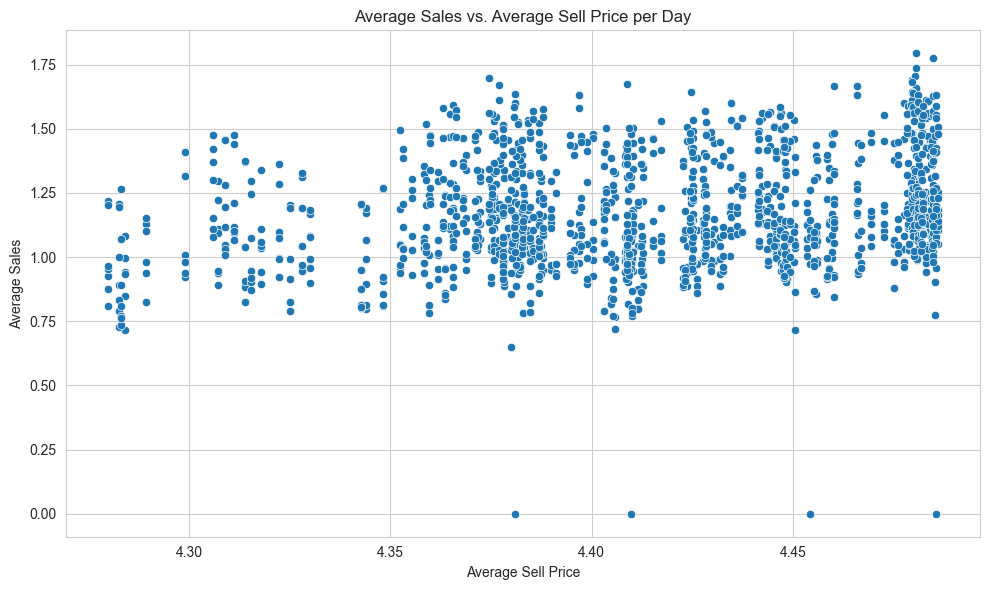

In [37]:
grouped_data = data.groupby('date').agg({'sales':'mean', 'sell_price':'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='sell_price', y='sales', data=grouped_data)

plt.title('Average Sales vs. Average Sell Price per Day')
plt.xlabel('Average Sell Price')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [188]:
daily_avg_sales = data.groupby(['date', 'combined_event_type'])['sales'].mean().reset_index()

baseline_avg_sales = daily_avg_sales[daily_avg_sales['combined_event_type'].isna()]['sales'].mean()
print(f"Baseline Average Sales (non-event days): {baseline_avg_sales}")

event_avg_sales = daily_avg_sales.groupby('combined_event_type')['sales'].mean()
print("\nEvent Type Average Sales:")
print(event_avg_sales)

relative_avg_sales = ((event_avg_sales - baseline_avg_sales) / baseline_avg_sales) * 100
print("\nRelative Average Sales:")
print(relative_avg_sales)


Baseline Average Sales (non-event days): nan

Event Type Average Sales:
combined_event_type
Cultural                1.170640
Cultural & Religious    1.276943
National                0.990448
Religious               1.164325
Religious & Cultural    1.416956
Sporting                1.192537
Sporting & Cultural     1.393703
Name: sales, dtype: float64

Relative Average Sales:
combined_event_type
Cultural               NaN
Cultural & Religious   NaN
National               NaN
Religious              NaN
Religious & Cultural   NaN
Sporting               NaN
Sporting & Cultural    NaN
Name: sales, dtype: float64


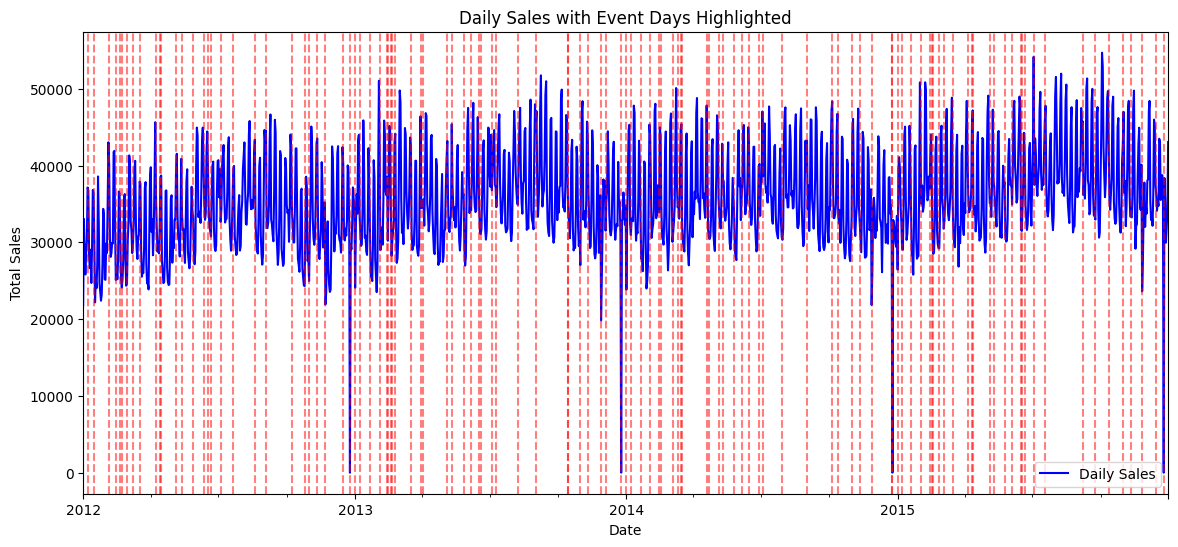

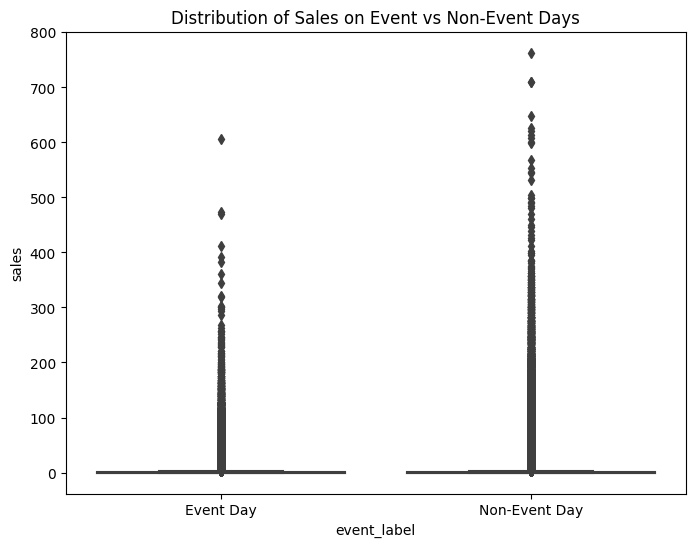

In [148]:
plt.figure(figsize=(8, 6))
data['event_label'] = data['is_event_or_holiday'].map({True: 'Event Day', False: 'Non-Event Day'})
sns.boxplot(x="event_label", y="sales", data=data)
plt.title("Distribution of Sales on Event vs Non-Event Days")
plt.show()

In [24]:
monthly_sales = df_daily.resample('M').sum()
quarterly_sales = df_daily.resample('Q').sum()
yearly_sales = df_daily.resample('Y').sum()

In [25]:
event_dates = pd.Series(data[data['is_event_or_holiday']]['date'].unique()).sort_values().reset_index(drop=True)
event_dates = event_dates[event_dates.dt.year != 2016]
event_dates.head()

0   2012-01-01
1   2012-01-07
2   2012-01-16
3   2012-02-05
4   2012-02-14
dtype: datetime64[ns]

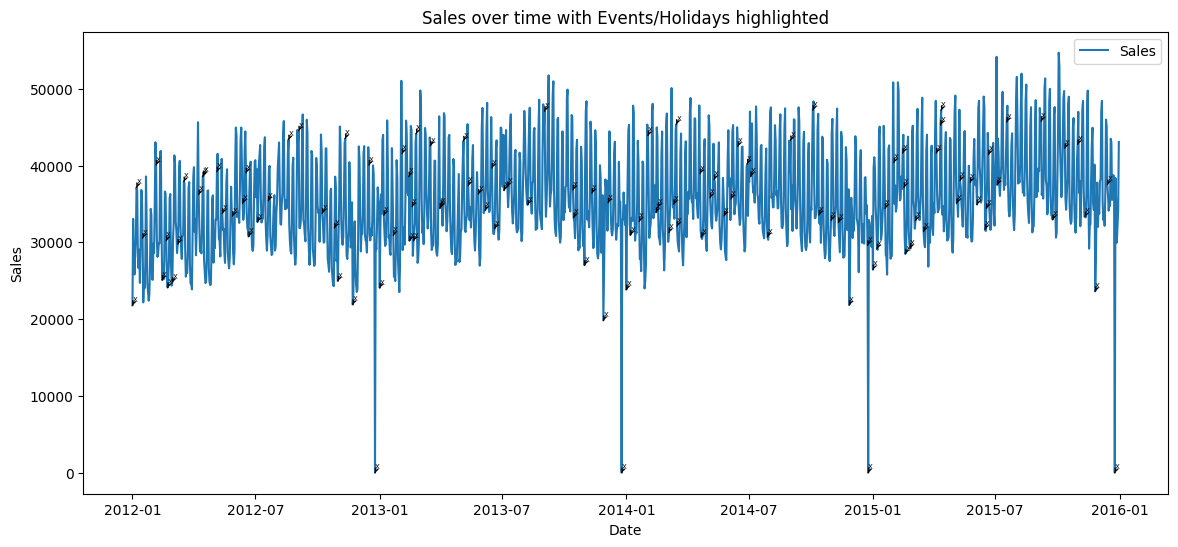

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['sales'], label='Sales')

for date in event_dates:
    plt.annotate('X', xy=(date, df_daily.loc[date, 'sales']), 
                 xytext=(date, df_daily.loc[date, 'sales'] + 500), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=5)

plt.title('Sales over time with Events/Holidays highlighted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
'''Histogram and Probability Density Plot: This gives you a sense of the data distribution.'''

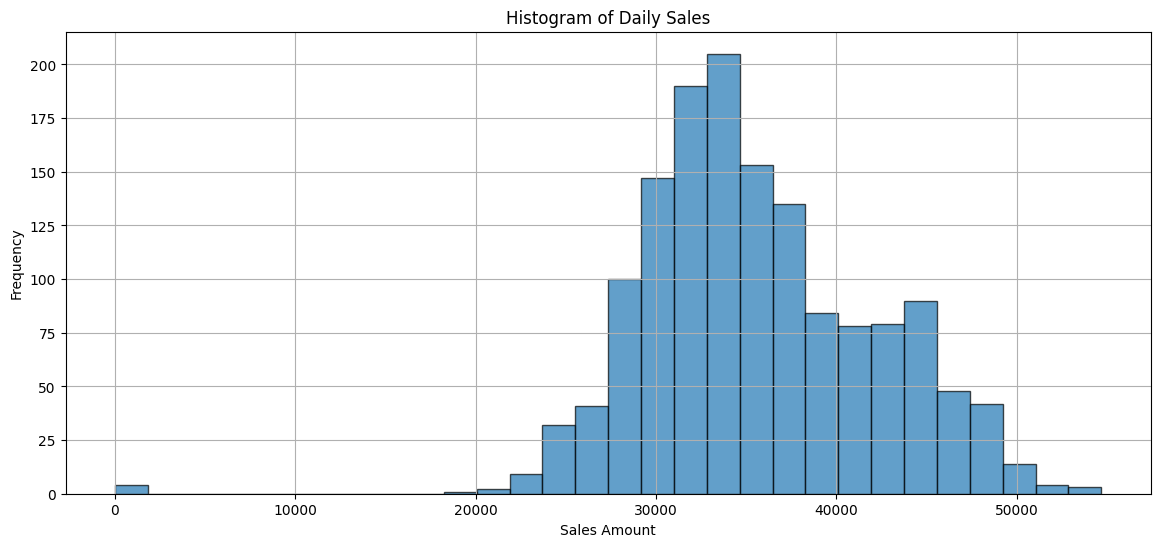

In [27]:
plt.figure(figsize=(14, 6))
plt.hist(df_daily['sales'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Daily Sales')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\Brian Silva\AppData\Local\Temp\ipykernel_16808\2487704129.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_daily['sales'], shade=True)


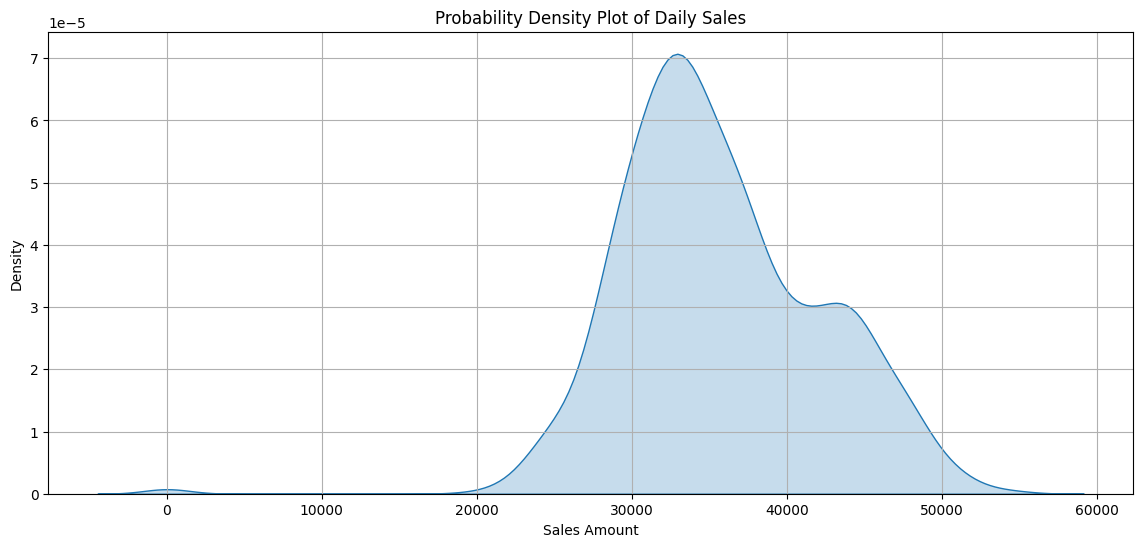

In [28]:
plt.figure(figsize=(14, 6))
sns.kdeplot(df_daily['sales'], shade=True)
plt.title('Probability Density Plot of Daily Sales')
plt.xlabel('Sales Amount')
plt.ylabel('Density')
plt.grid(True)
plt.show()

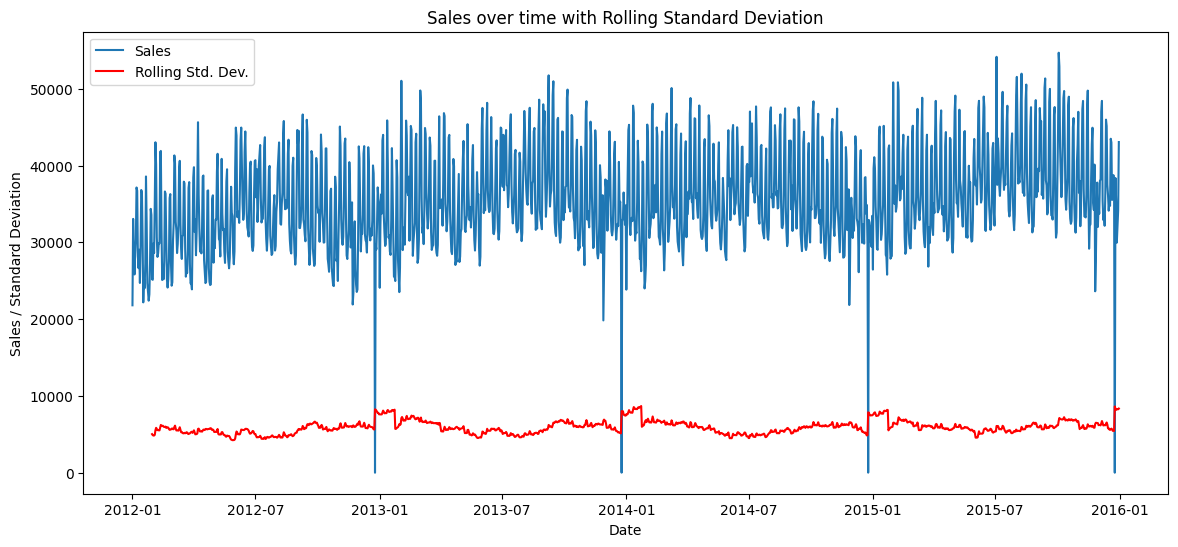

In [29]:
plt.figure(figsize=(14, 6))
df_daily['rolling_std'] = df_daily['sales'].rolling(window=30).std()  # Using a 30-day window
plt.plot(df_daily.index, df_daily['sales'], label='Sales')
plt.plot(df_daily.index, df_daily['rolling_std'], label='Rolling Std. Dev.', color='red')
plt.title('Sales over time with Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sales / Standard Deviation')
plt.legend()
plt.show()


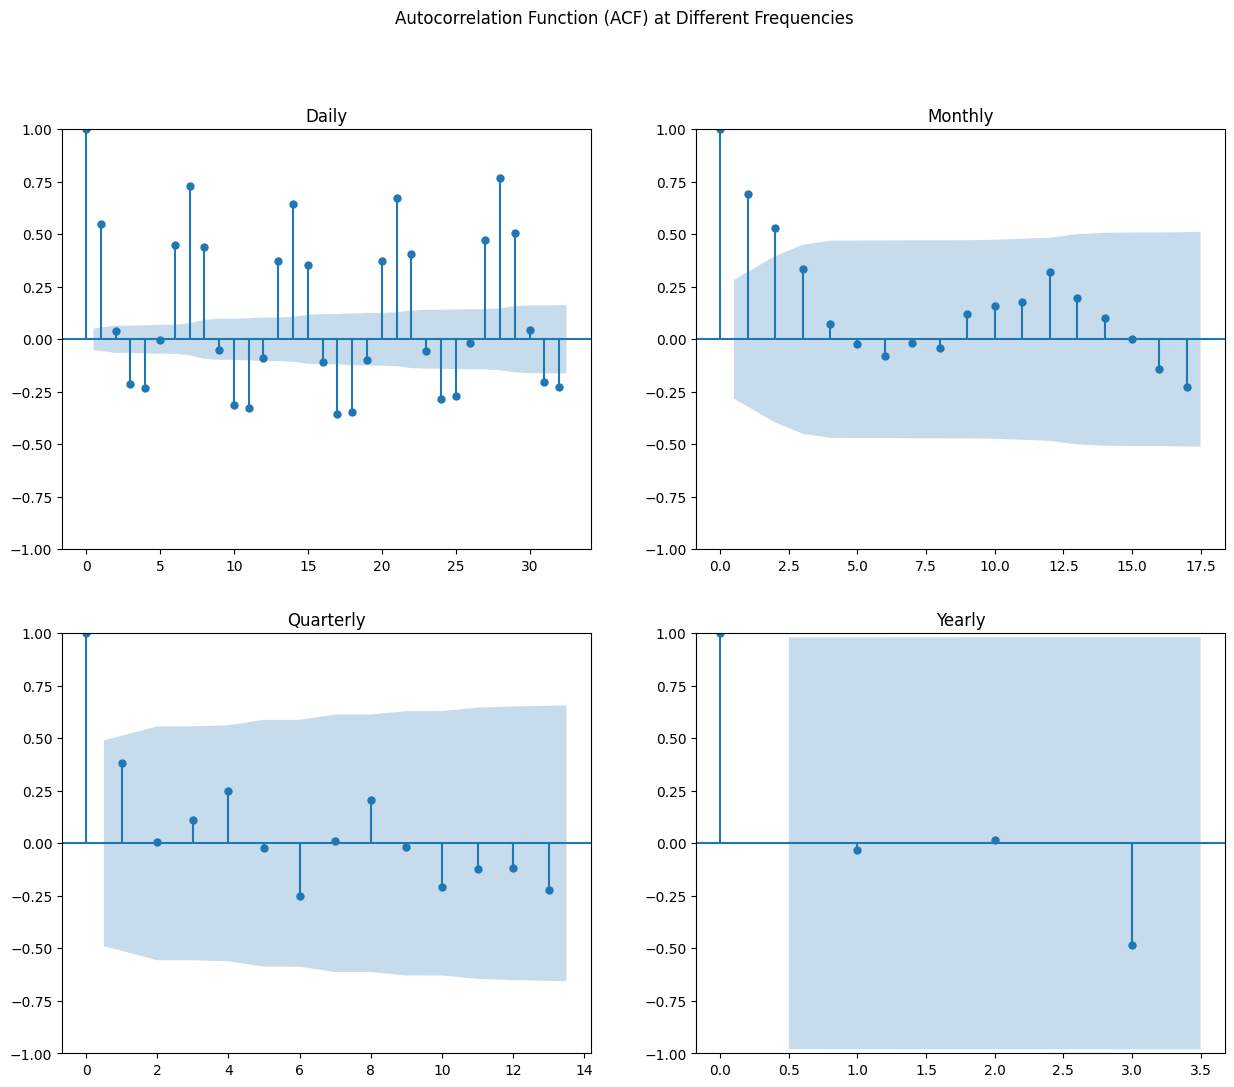

In [34]:
sales_data = df_daily['sales']
monthly_data = monthly_sales['sales']
quarterly_data = quarterly_sales['sales']
yearly_data = yearly_sales['sales']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Autocorrelation Function (ACF) at Different Frequencies')

plot_acf(sales_data, ax=axes[0, 0], title='Daily')
plot_acf(monthly_data, ax=axes[0, 1], title='Monthly')
plot_acf(quarterly_data, ax=axes[1, 0], title='Quarterly')
plot_acf(yearly_data, ax=axes[1, 1], title='Yearly')
plt.show()

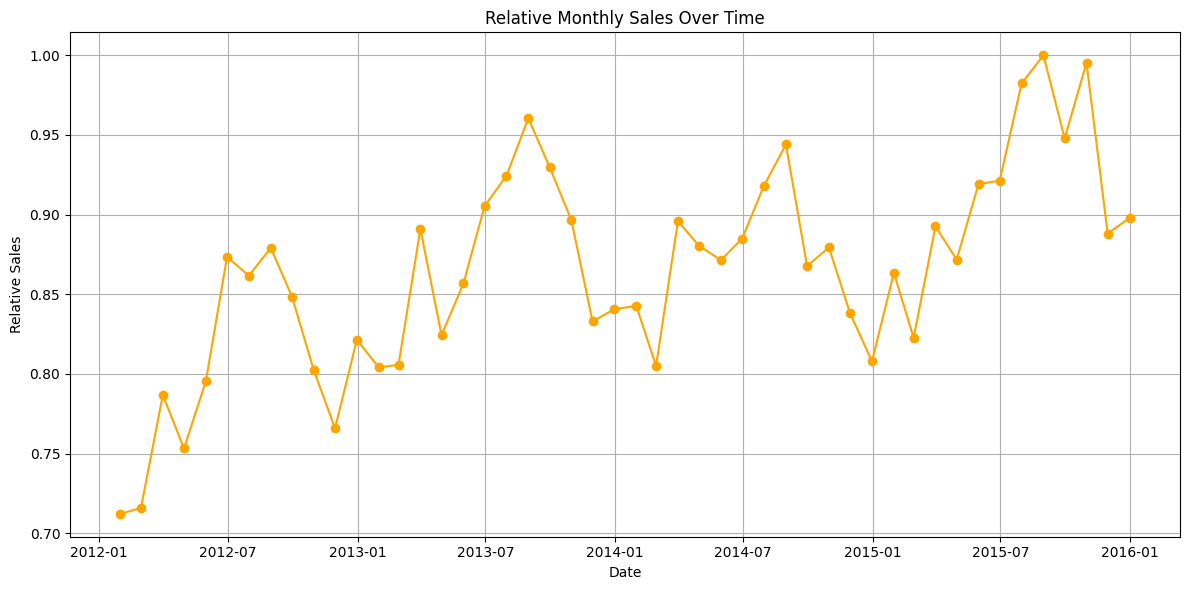

In [47]:
df_monthly = data.resample('M', on='date')['sales'].sum().reset_index()

df_monthly['relative_sales'] = df_monthly['sales'] / df_monthly['sales'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['date'], df_monthly['relative_sales'], label='Relative Monthly Sales', marker='o', color='orange')
plt.title('Relative Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Relative Sales')
plt.grid()
plt.tight_layout()
plt.show()


In [58]:
# Loess smoothing (using statsmodels library)
smoothed = lowess(df_daily['sales'], df_daily.index)
df_daily['loess'] = smoothed[:, 1]

df_daily['mean_sales'] = df_daily['sales'].mean()
df_daily['sales_rel'] = (df_daily['sales'] - df_daily['loess']) / df_daily['mean_sales']

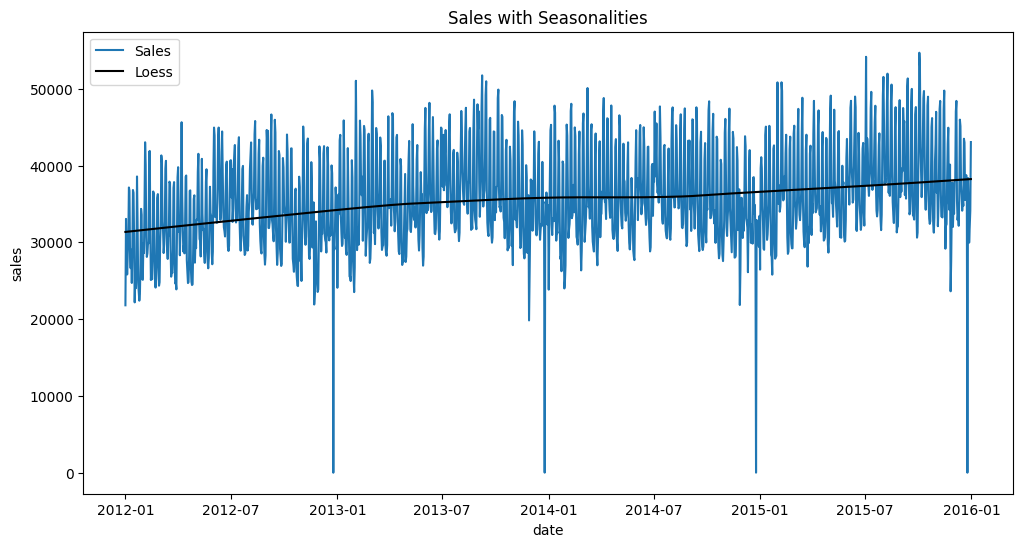

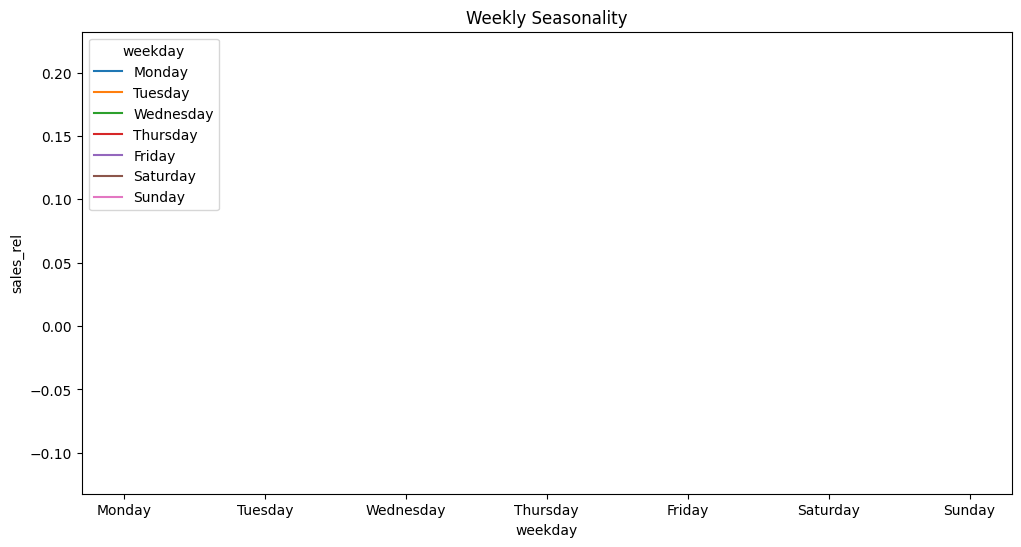

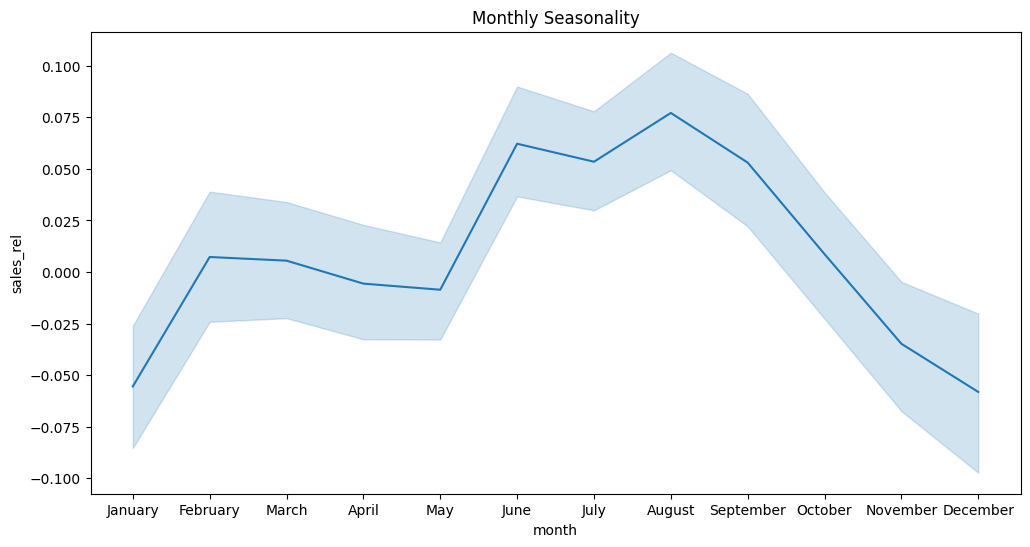

In [66]:
# First plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='date', y='sales', label='Sales')
sns.lineplot(data=df_daily, x='date', y='loess', label='Loess', color='black')
plt.title('Sales with Seasonalities')
plt.show()


df_daily['month'] = df_daily['date'].dt.month_name()
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='month', y='sales_rel')
plt.title('Monthly Seasonality')
plt.show()

In [24]:
model = LinearRegression()
model.fit(data.index.values.reshape(-1, 1), data['sales'])

slope = model.coef_[0]

print(f"The estimated trend rate is {slope}")

The estimated trend rate is 2.6938507413383933e-18


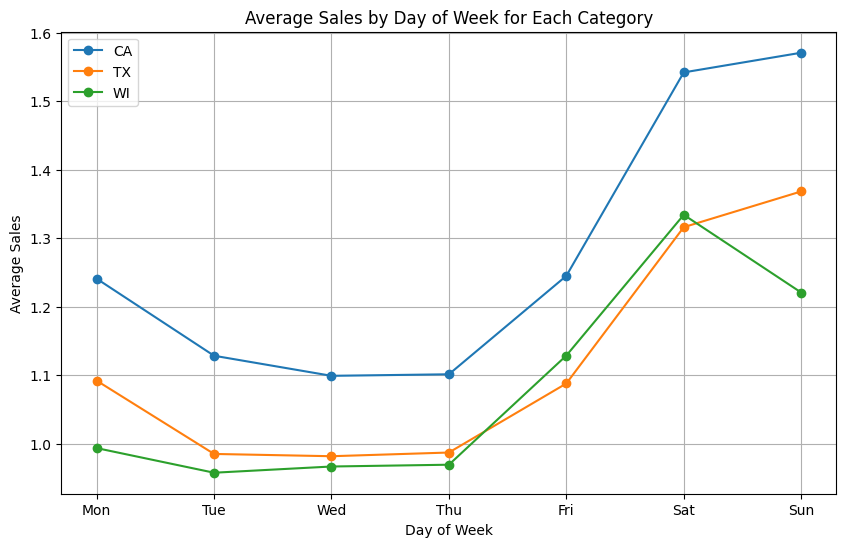

In [69]:
weekly_sales_category = data.groupby(['state_id', 'weekday'])['sales'].mean()

categories = data['state_id'].unique()

plt.figure(figsize=(10,6))

for category in categories:
    plt.plot(weekly_sales_category[category].index, weekly_sales_category[category].values, marker='o', label=category)

plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of Week for Each Category')
plt.grid()
plt.legend()
plt.show()

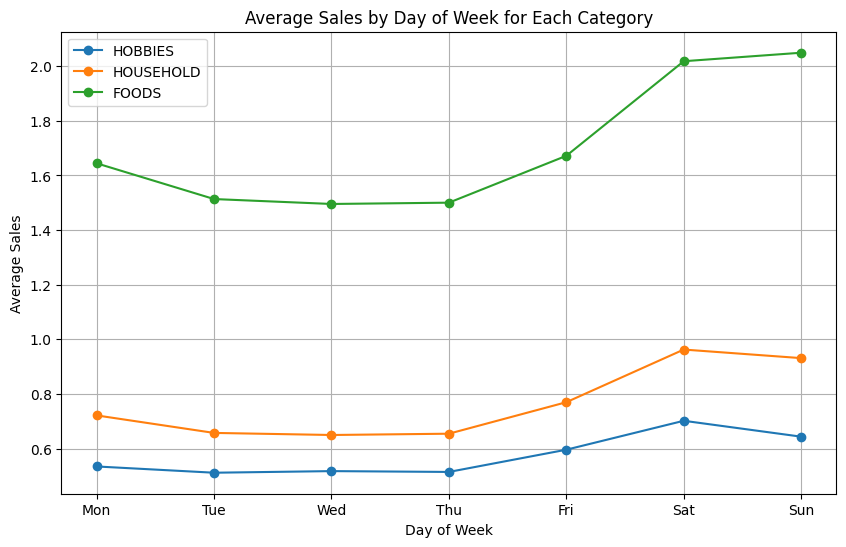

In [40]:
weekly_sales_category = data.groupby(['state_id', 'weekday'])['sales'].mean()

categories = data['state_id'].unique()

plt.figure(figsize=(10,6))

for category in categories:
    plt.plot(weekly_sales_category[category].index, weekly_sales_category[category].values, marker='o', label=category)

plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of Week for Each Category')
plt.grid()
plt.legend()
plt.show()


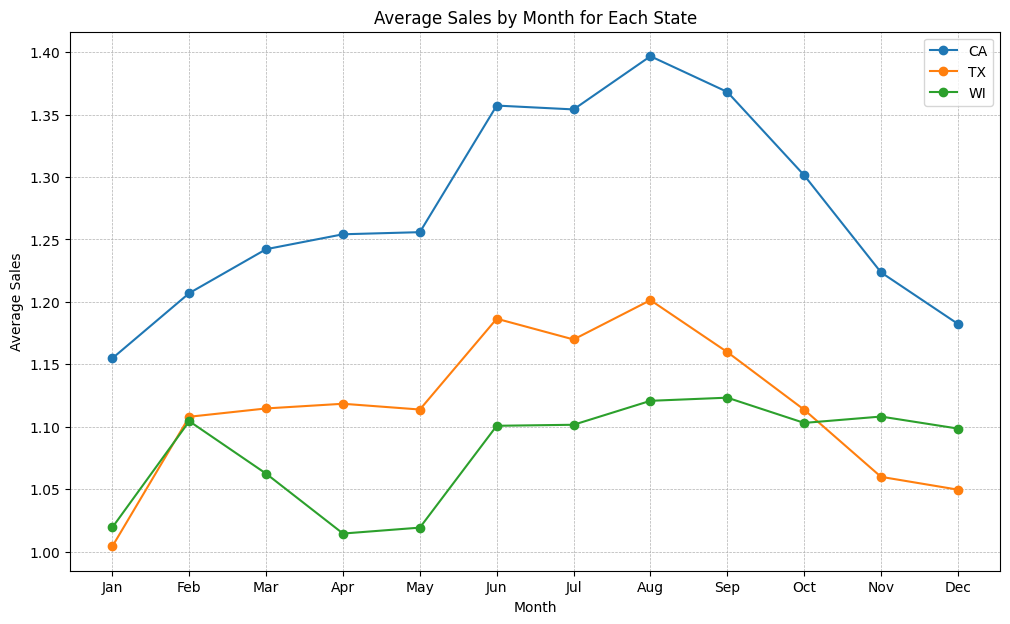

In [71]:
data['month'] = data['date'].dt.month
monthly_sales_state = data.groupby(['state_id', 'month'])['sales'].mean()
states = data['state_id'].unique()

plt.figure(figsize=(12,7))

for state in states:
    plt.plot(monthly_sales_state[state].index, monthly_sales_state[state].values, marker='o', label=state)

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales by Month for Each State')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


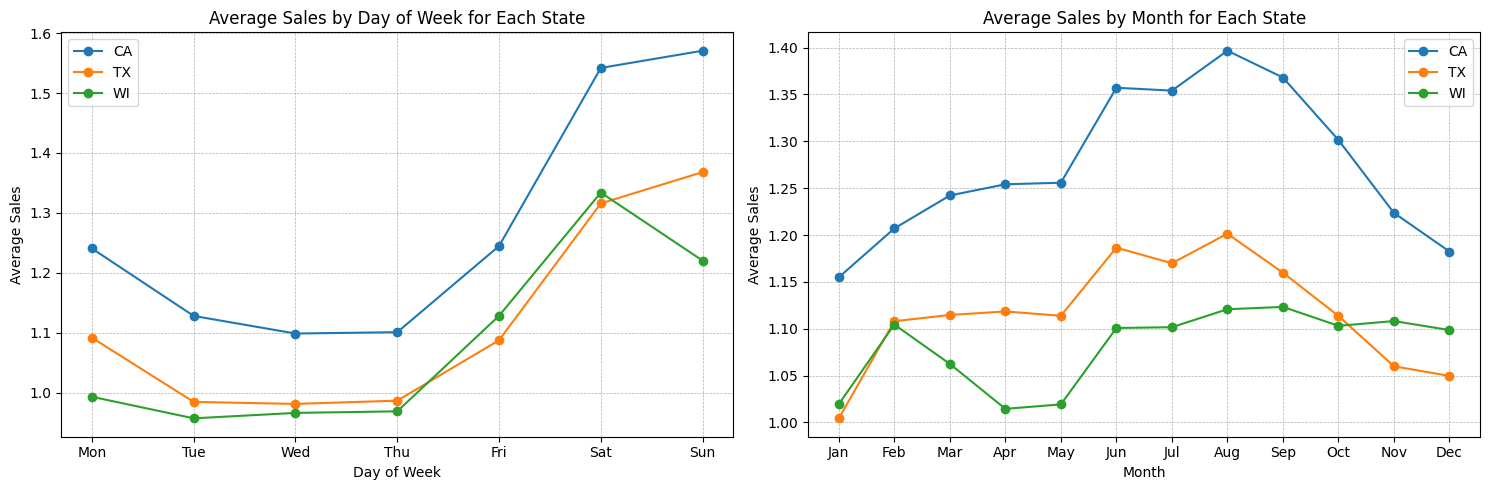

In [77]:
weekly_sales_state = data.groupby(['state_id', 'weekday'])['sales'].mean()
data['month'] = data['date'].dt.month

monthly_sales_state = data.groupby(['state_id', 'month'])['sales'].mean()

states = data['state_id'].unique()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for state in states:
    axes[0].plot(weekly_sales_state[state].index, weekly_sales_state[state].values, marker='o', label=state)

axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Sales')
axes[0].set_title('Average Sales by Day of Week for Each State')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].legend()

for state in states:
    axes[1].plot(monthly_sales_state[state].index, monthly_sales_state[state].values, marker='o', label=state)

axes[1].set_xticks(np.arange(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Sales')
axes[1].set_title('Average Sales by Month for Each State')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()


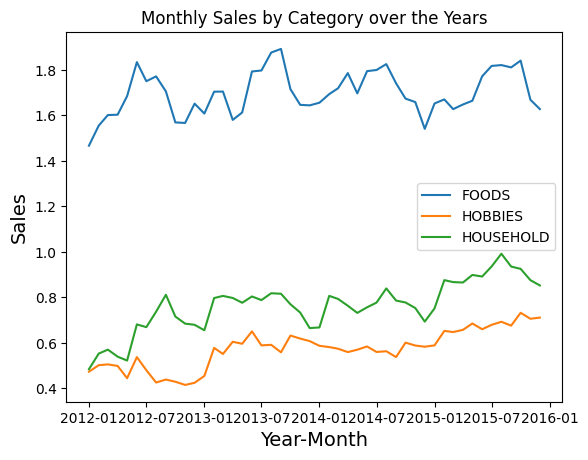

In [44]:
data['year_month'] = data['year'].astype(str) + '-' + data['month'].astype(str).str.zfill(2)
data['year_month'] = pd.to_datetime(data['year_month'])

monthly_sales_category = data.groupby(['year_month', 'cat_id'])['sales'].mean().reset_index()

fig, ax = plt.subplots()

for category in monthly_sales_category['cat_id'].unique():
    ax.plot(monthly_sales_category[monthly_sales_category['cat_id'] == category]['year_month'], 
            monthly_sales_category[monthly_sales_category['cat_id'] == category]['sales'], 
            label=category)

ax.set_xlabel("Year-Month",fontsize=14)
ax.set_ylabel("Sales",fontsize=14)
ax.set_title("Monthly Sales by Category over the Years")
ax.legend()
plt.show()
